# Practical 10: Clustering analysis

This week, we will focus on clustering analysis on the attainment and
disadvantage variables of schools in England, aiming to identify the
groups within these schools in terms of attainment and disadvantange
dimensions.

The practical consists of the following steps:

1.  Load the national school performance dataset.
2.  Filter to schools in Greater London.
3.  Select a subset of variables related to disadvantage and attainment.
4.  Handle missing values and standardise the data.
5.  Run **K-means** and **hierarchical (agglomerative)** clustering.
6.  Compare the two clustering results.
7.  Map the schools using their geospatial locations.

## Setup

We first import the Python libraries needed for data handling,
clustering, and plotting.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (8, 6)

## Load school data

We now load the DfE school dataset of 2022-2023.

In [2]:
url_school = "https://raw.githubusercontent.com/huanfachen/QM/refs/heads/main/sessions/L6_data/Performancetables_130242/2022-2023/england_filtered.csv"

df_school = pd.read_csv(url_school)

print(df_school.shape)

print(df_school.head())

(3056, 37)
      URN                                  SCHNAME.x  LEA  LANAME  TOWN.x  \
0  100053                     Acland Burghley School  202  Camden  London   
1  100054                The Camden School for Girls  202  Camden  London   
2  100052                           Hampstead School  202  Camden  London   
3  100049                          Haverstock School  202  Camden  London   
4  100059  La Sainte Union Catholic Secondary School  202  Camden  London   

  gor_name  TOTPUPS  ATT8SCR  ATT8SCRENG  ATT8SCRMAT  ...  PPERSABS10  \
0   London   1163.0     50.3        10.7        10.2  ...        24.7   
1   London   1047.0     65.8        13.5        12.7  ...         6.6   
2   London   1319.0     44.6         9.7         9.1  ...        24.0   
3   London    982.0     41.7         8.7         8.8  ...        33.1   
4   London    817.0     49.6        10.8         9.4  ...        33.8   

             SCHOOLTYPE.x         RELCHAR       ADMPOL.y      ADMPOL_PT  \
0  State-fun

## Load LAD-to-county lookup and filter to London

We need to keep only schools in **Inner London** or **Outer London**. To
do this, we join a LAD-to-county lookup table to the school data.

In [3]:
# Raw link to the lookup table
url_lad_county = "https://raw.githubusercontent.com/huanfachen/QM/refs/heads/main/sessions/L10_data/Local_Authority_District_to_County_(December_2024)_Lookup_in_EN.csv"

df_lad_county = pd.read_csv(url_lad_county)

print(df_lad_county.head())

     LAD24CD               LAD24NM    CTY24CD         CTY24NM  ObjectId
0  E07000008             Cambridge  E10000003  Cambridgeshire         1
1  E07000009   East Cambridgeshire  E10000003  Cambridgeshire         2
2  E07000010               Fenland  E10000003  Cambridgeshire         3
3  E07000011       Huntingdonshire  E10000003  Cambridgeshire         4
4  E07000012  South Cambridgeshire  E10000003  Cambridgeshire         5

Now, we join the lookup to the school data:

-   Match `LANAME` in `df_school` with `LAD24NM` in `df_lad_county`.  
-   Keep only rows where `CTY24NM` is **Inner London** or **Outer
    London**.

In [4]:
# Merge school data with LAD→County lookup
df_school_london = df_school.merge(
    df_lad_county[["LAD24NM", "CTY24NM"]],
    left_on="LANAME",
    right_on="LAD24NM",
    how="left"
)

# Filter to Inner and Outer London
london_filter = df_school_london["CTY24NM"].isin(["Inner London", "Outer London"])
df_school_london = df_school_london[london_filter].copy()

df_school_london["CTY24NM"].value_counts()

CTY24NM
Outer London    294
Inner London    149
Name: count, dtype: int64

## Select clustering variables

The metadata of the school data is available
[here](https://github.com/huanfachen/QM/blob/main/sessions/L6_data/Performancetables_130249/2022-2023/census_meta.csv).
For convenience, the columns are described as below:  
1. **URN**: Unique Reference Number identifying a school.  
2. **SCHNAME.x**: School name as recorded in the official register.  
3. **LEA**: Local Education Authority (code).  
4. **LANAME**: Name of the Local Authority.  
5. **TOWN.x**: Town in which the school is located.  
6. **gor_name**: Government Office Region name.  
7. **TOTPUPS**: Total number of pupils on roll.  
8. **ATT8SCR**: Average Attainment 8 score for all pupils.  
9. **ATT8SCRENG**: Average Attainment 8 score for English subject
grouping.  
10. **ATT8SCRMAT**: Average Attainment 8 score for Maths subject
grouping.  
11. **ATT8SCR_FSM6CLA1A**: Average Attainment 8 score for pupils
eligible for Free School Meals in the last 6 years and/or Children
Looked After.  
12. **ATT8SCR_NFSM6CLA1A**: Average Attainment 8 score for pupils not
eligible for Free School Meals in the last 6 years and not Children
Looked After.  
13. **ATT8SCR_BOYS**: Average Attainment 8 score for male pupils.  
14. **ATT8SCR_GIRLS**: Average Attainment 8 score for female pupils.  
15. **P8MEA**: Progress 8 measure for all pupils.  
16. **P8MEA_FSM6CLA1A**: Progress 8 measure for disadvantaged pupils
(FSM6 and/or CLA1A).  
17. **P8MEA_NFSM6CLA1A**: Progress 8 measure for non-disadvantaged
pupils.  
18. **PTFSM6CLA1A**: Percentage of pupils eligible for FSM6 and/or
CLA1A.  
19. **PTNOTFSM6CLA1A**: Percentage of pupils not eligible for FSM6
and/or CLA1A.  
20. **PNUMEAL**: Percentage of pupils whose first language is known or
believed to be other than English.  
21. **PNUMENGFL**: Percentage of pupils whose first language is
English.  
22. **PTPRIORLO**: Percentage of pupils with low prior attainment from
Key Stage 2.  
23. **PTPRIORHI**: Percentage of pupils with high prior attainment from
Key Stage 2.  
24. **NORB**: Number of boys on roll.  
25. **NORG**: Number of girls on roll.  
26. **PNUMFSMEVER**: Percentage of pupils who have been eligible for
free school meals in the past six years (FSM6 measure).  
27. **PERCTOT**: Percentage of total pupil absence (authorised and
unauthorised combined).  
28. **PPERSABS10**: Percentage of pupils who are persistently absent
(overall absence rate 10% or more).  
29. **SCHOOLTYPE.x**: Official classification of the school type (e.g.,
Academy, Community, Voluntary Aided).  
30. **RELCHAR**: Religious character of the school (e.g., Church of
England, Roman Catholic, None).  
31. **ADMPOL.y**: Admission policy type (e.g., non-selective,
selective).  
32. **ADMPOL_PT**: Percentage breakdown related to admission policy
(context-specific).  
33. **gender_name**: Gender intake of the school (Mixed, Boys, Girls).  
34. **OFSTEDRATING**: Latest Ofsted inspection overall effectiveness
grade.  
35. **MINORGROUP**: Ethnic minority group classification for aggregation
purposes.  
36. **easting**: Ordnance Survey Easting coordinate of school
location.  
37. **northing**: Ordnance Survey Northing coordinate of school
location.

As the focus is to explore the performance and disadvantage of schools,
we will keep the following variables, which is the same as Week-9:

1.  **PTFSM6CLA1A** – Percentage of pupils eligible for Free School
    Meals in the past six years (FSM6) and/or Children Looked After
    (CLA1A).  
2.  **PTNOTFSM6CLA1A** – Percentage of pupils not eligible for FSM6 and
    not CLA1A.  
3.  **PNUMEAL** – Percentage of pupils whose first language is known or
    believed to be other than English.  
4.  **PNUMFSMEVER** – Percentage of pupils who have ever been eligible
    for Free School Meals in the past six years (FSM6 measure).  
5.  **ATT8SCR_FSM6CLA1A** – Average Attainment 8 score for pupils
    eligible for FSM6 and/or CLA1A.  
6.  **ATT8SCR_NFSM6CLA1A** – Average Attainment 8 score for pupils not
    eligible for FSM6 and not CLA1A.  
7.  **ATT8SCR_BOYS** – Average Attainment 8 score for male pupils.  
8.  **ATT8SCR_GIRLS** – Average Attainment 8 score for female pupils.  
9.  **P8MEA_FSM6CLA1A** – Progress 8 measure for disadvantaged pupils
    (FSM6 and/or CLA1A).  
10. **P8MEA_NFSM6CLA1A** – Progress 8 measure for non-disadvantaged
    pupils.

In [5]:
cols_for_clustering = [
    "PTFSM6CLA1A", "PTNOTFSM6CLA1A", "PNUMEAL", "PNUMFSMEVER",
    "ATT8SCR_FSM6CLA1A", "ATT8SCR_NFSM6CLA1A", "ATT8SCR_BOYS", "ATT8SCR_GIRLS",
    "P8MEA_FSM6CLA1A", "P8MEA_NFSM6CLA1A"
]

df_school_reduced = df_school_london[cols_for_clustering].copy()
df_school_reduced.head()

## Check and handle missing values

Clustering algorithms cannot directly work with missing values, so we
have to handle them. We will use **KNN imputation**, which fills in
missing values based on similar rows.

In [6]:
df_school_reduced.isna().sum()

PTFSM6CLA1A           11
PTNOTFSM6CLA1A        11
PNUMEAL                2
PNUMFSMEVER            2
ATT8SCR_FSM6CLA1A     20
ATT8SCR_NFSM6CLA1A    19
ATT8SCR_BOYS          86
ATT8SCR_GIRLS         63
P8MEA_FSM6CLA1A       23
P8MEA_NFSM6CLA1A      21
dtype: int64

In [7]:
# Use K-nearest neighbours imputation (k = 5)
imputer = KNNImputer(n_neighbors=5)

reduced_imputed_array = imputer.fit_transform(df_school_reduced)

df_reduced_imputed = pd.DataFrame(
    reduced_imputed_array,
    columns=cols_for_clustering,
    index=df_school_london.index
)

df_reduced_imputed.head()

For each missing value, KNNImputer looks at the 5 most similar schools
and uses their values to fill the gap. This helps us keep as many London
schools as possible in the analysis.

## Standardise variables

Different variables are measured on different scales (e.g. ratio vs
scores). To avoid one variable dominating the distance measure, we
standardise them so each has mean $$0$$ and standard deviation $$1$$.

In [8]:
scaler = StandardScaler()

scaled_array = scaler.fit_transform(df_reduced_imputed)

df_scaled = pd.DataFrame(
    scaled_array,
    columns=cols_for_clustering,
    index=df_school_london.index
)

df_scaled.describe().T

After scaling, each variable is on a similar scale, which makes
distance-based methods like K-means and hierarchical clustering more
sensible.

## K-means clustering

We now run **K-means** on the scaled data. We need to choose the number
of clusters $$k$$. We will:

1.  Try different values of *k*.  
2.  Plot the **inertia** (within-cluster sum of squares).  
3.  Use the **elbow method** to pick a reasonable $$k$$.

### Elbow plot to choose $$k$$

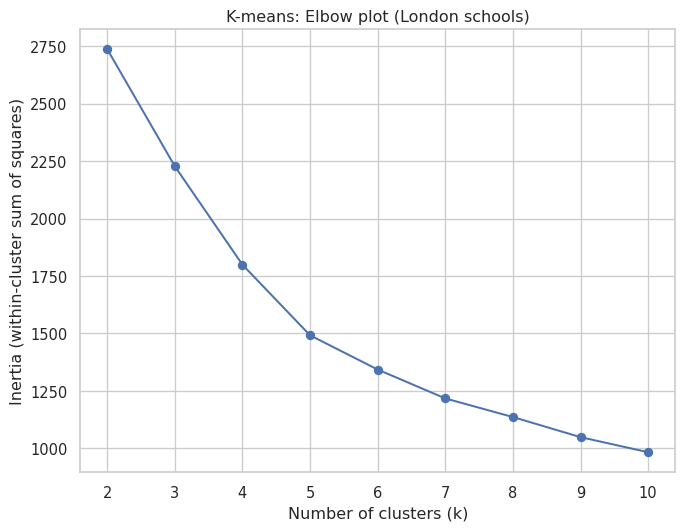

In [9]:
inertias = []
k_values = range(2, 11)  # try k = 2 to 10

for k in k_values:
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init="auto"
    )
    kmeans.fit(df_scaled)
    inertias.append(kmeans.inertia_)

plt.figure()
plt.plot(k_values, inertias, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (within-cluster sum of squares)")
plt.title("K-means: Elbow plot (London schools)")
plt.xticks(k_values)
plt.show()

In this elbow plot, each point shows how *tight* the clusters are for
that *k*, and we are looking for a “bend” or “elbow” where increasing
*k* gives only small improvements. This *k* represents a good trade-off
between model complexity (i.e. number of clusters) and performance.
Here, we will choose k=5

### Fit K-means with chosen $$k$$

In [10]:
k_val = 5 

kmeans_final = KMeans(
    n_clusters=k_val,
    random_state=42,
    n_init="auto"
)

kmeans_final.fit(df_scaled)

kmeans_labels = kmeans_final.labels_

# Store labels in the London school dataframe
df_school_london["cluster_kmeans"] = kmeans_labels

print(df_school_london["cluster_kmeans"].value_counts().sort_index())

cluster_kmeans
0     20
1     83
2    111
3    118
4    111
Name: count, dtype: int64

### Inspect K-means cluster centroids

We will look at the *typical* school in each cluster by examining the
cluster centroids back in the original units.

In [11]:
centroids_scaled = kmeans_final.cluster_centers_
centroids_original = scaler.inverse_transform(centroids_scaled)

df_centroids = pd.DataFrame(
    centroids_original,
    columns=cols_for_clustering
)
df_centroids.index = [f"Cluster {i}" for i in range(k_val)]

print(df_centroids)

           PTFSM6CLA1A  PTNOTFSM6CLA1A    PNUMEAL  PNUMFSMEVER  \
Cluster 0     7.350000       92.700000  34.795000     8.125000   
Cluster 1    44.602410       55.424096  44.860241    46.492771   
Cluster 2    23.940741       76.059426  25.184156    25.829754   
Cluster 3    44.986441       55.013559  53.217797    46.264407   
Cluster 4    20.106306       79.902703  33.760360    21.265766   

           ATT8SCR_FSM6CLA1A  ATT8SCR_NFSM6CLA1A  ATT8SCR_BOYS  ATT8SCR_GIRLS  \
Cluster 0          76.120000           79.683000     78.516000      79.736000   
Cluster 1          35.532048           44.074940     39.069157      42.077590   
Cluster 2          39.858803           52.114166     47.990934      51.002290   
Cluster 3          46.191864           53.223729     48.102203      51.559322   
Cluster 4          50.031712           61.180180     57.813874      59.716036   

           P8MEA_FSM6CLA1A  P8MEA_NFSM6CLA1A  
Cluster 0         0.796200          0.953400  
Cluster 1        -0.57

### Plot of K-means cluster centroids

We will use the following code to visualise the cluster centroids in
multiple dimensions.

In [12]:
# adapted from this tutorial: https://towardsdatascience.com/how-to-make-stunning-radar-charts-with-python-implemented-in-matplotlib-and-plotly-91e21801d8ca
def radar_plot_cluster_centroids(df_cluster_centroid):
    # parameters
    # df_cluster_centroid: a dataframe with rows representing a cluster centroid and columns representing variables
    
    # manually 'close' the line
    categories = df_cluster_centroid.columns.values.tolist()
    categories = [*categories, categories[0]]
    
    label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(categories))
    
    plt.figure(figsize=(12, 8))
    plt.subplot(polar=True)
    for index, row in df_cluster_centroid.iterrows():
        centroid = row.tolist()
        centroid = [*centroid, centroid[0]]
        label = "{}".format(index)
        plt.plot(label_loc, centroid, label=label)
    plt.title('Cluster centroid comparison', size=20, y=1.05)
    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
    plt.legend(loc="upper right")
    plt.show()

Can you observe and describe the difference between cluster centroids?

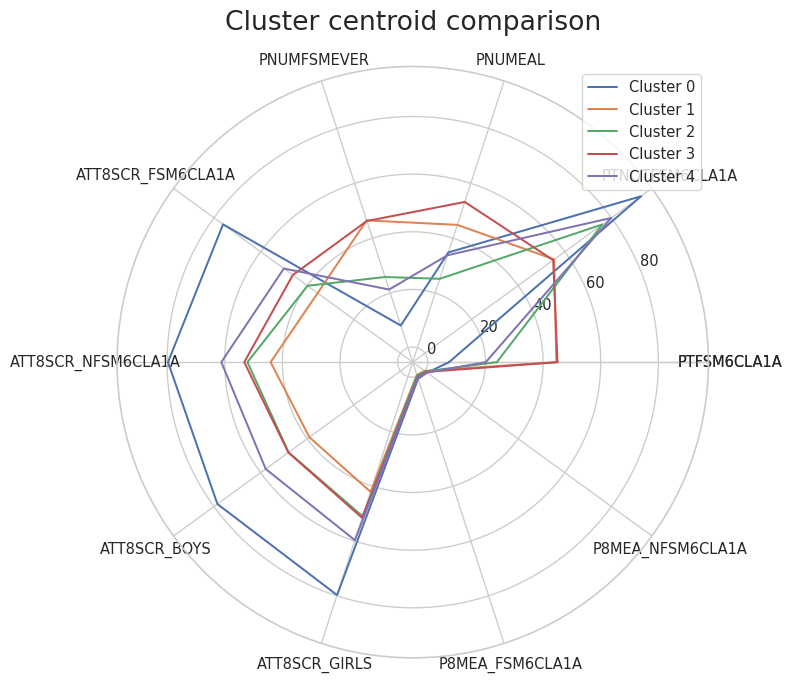

In [13]:
radar_plot_cluster_centroids(df_centroids)

### Visualising clusters with selected variables

To visualise all data points coloured by the clusters, we can pick up
two variables (such as Attainment 8 for FSM vs non-FSM students) and
create a scatterplot.

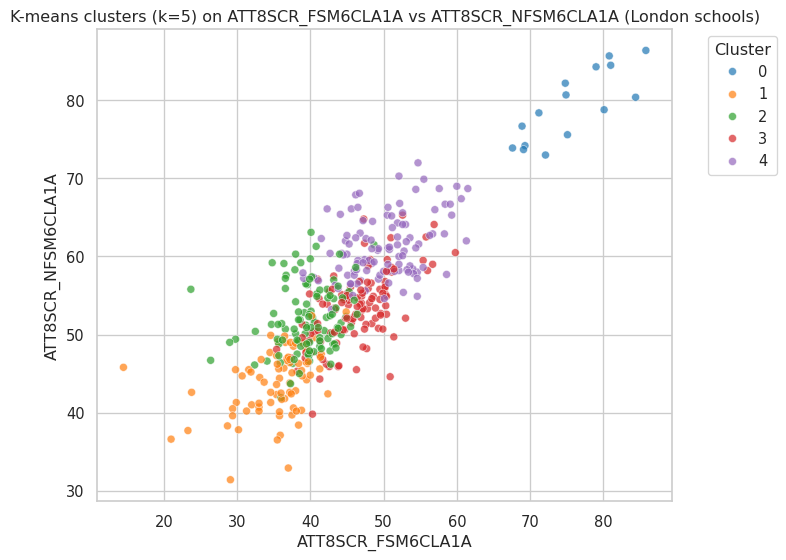

In [14]:
x_var = "ATT8SCR_FSM6CLA1A"
y_var = "ATT8SCR_NFSM6CLA1A"

plt.figure()
sns.scatterplot(
    data=df_school_london,
    x=x_var, y=y_var,
    hue="cluster_kmeans",
    palette="tab10",
    alpha=0.7
)
plt.title(f"K-means clusters (k={k_val}) on {x_var} vs {y_var} (London schools)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

## Hierarchical (Agglomerative) clustering

We now apply **hierarchical clustering** using
`AgglomerativeClustering`. This builds a tree (dendrogram) that shows
how clusters are merged step-by-step.

### Helper function to plot dendrogram

We reconstruct a linkage matrix from the fitted model, following the
pattern used in scikit-learn tutorials.

In [15]:
def plot_dendrogram(model, **kwargs):
    """
    Plot a dendrogram for a fitted AgglomerativeClustering model.

    This reconstructs the linkage matrix from the model's children_ and distances_.
    """
    # Number of samples
    n_samples = len(model.labels_)

    # Count samples under each node
    counts = np.zeros(model.children_.shape[0])
    for i, (left_child, right_child) in enumerate(model.children_):
        count = 0
        for child in (left_child, right_child):
            if child < n_samples:
                count += 1  # leaf
            else:
                count += counts[child - n_samples]
        counts[i] = count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)

### Fit hierarchical model

We first fit a model that builds the full tree so that we can draw the
dendrogram.

In [16]:
agg_full = AgglomerativeClustering(
    distance_threshold=0,
    n_clusters=None,
    metric="euclidean",
    linkage="ward"
)

agg_full = agg_full.fit(df_scaled)

### Plot truncated dendrogram

We only show the top few levels so the plot is not too crowded.

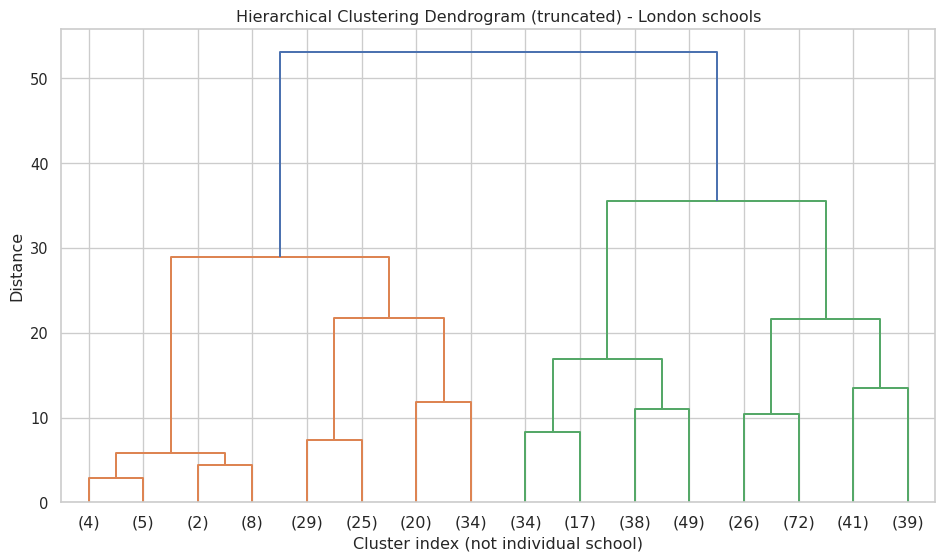

In [17]:
plt.figure(figsize=(10, 6))
plt.title("Hierarchical Clustering Dendrogram (truncated) - London schools")

plot_dendrogram(
    agg_full,
    truncate_mode="level",  # show only upper levels
    p=3                     # number of levels to show
)

plt.xlabel("Cluster index (not individual school)")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

-   Each merge in the tree shows two clusters being joined.  
-   A big vertical jump suggests a natural place to cut the tree into a
    small number of clusters.### Cut tree into a chosen number of
    clusters

We now choose a number of clusters (e.g. 5, for easier comparison with
K-means).

In [18]:
n_clusters_hier = 5

agg_cut = AgglomerativeClustering(
    n_clusters=n_clusters_hier,
    metric="euclidean",
    linkage="ward"
)

hier_labels = agg_cut.fit_predict(df_scaled)

df_school_london = df_school_london.assign(cluster_hier=hier_labels)

df_school_london["cluster_hier"].value_counts().sort_index()

cluster_hier
0    178
1     54
2    138
3     19
4     54
Name: count, dtype: int64

### Plot of hierarchical cluster centroids

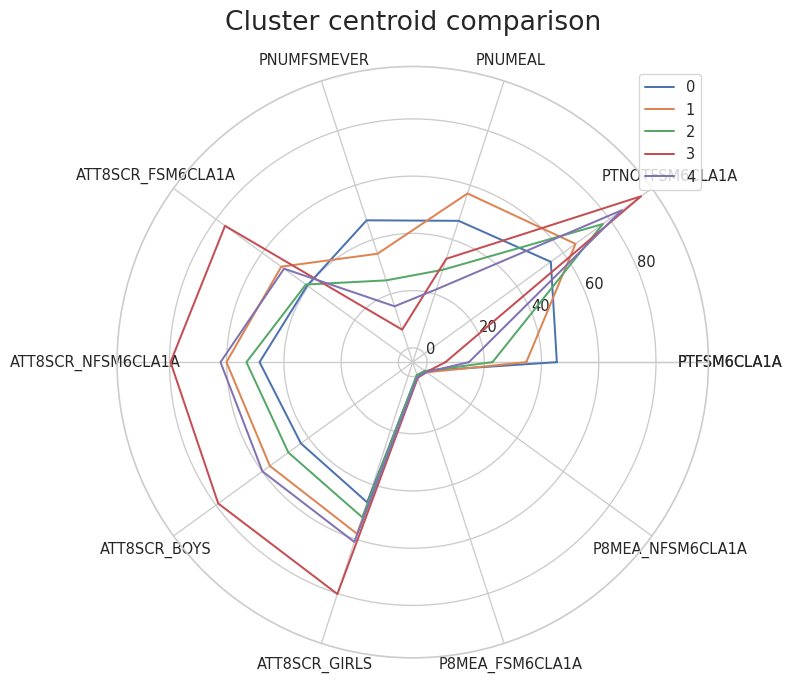

In [19]:
df_hc = df_school_reduced.copy()
df_hc = df_hc.assign(cluster_hier=hier_labels)
df_hc_centroid = df_hc.groupby('cluster_hier').mean()

radar_plot_cluster_centroids(df_hc_centroid)

### Visualising clusters with selected variables

We reuse the same two attainment variables but colour by hierarchical
cluster.

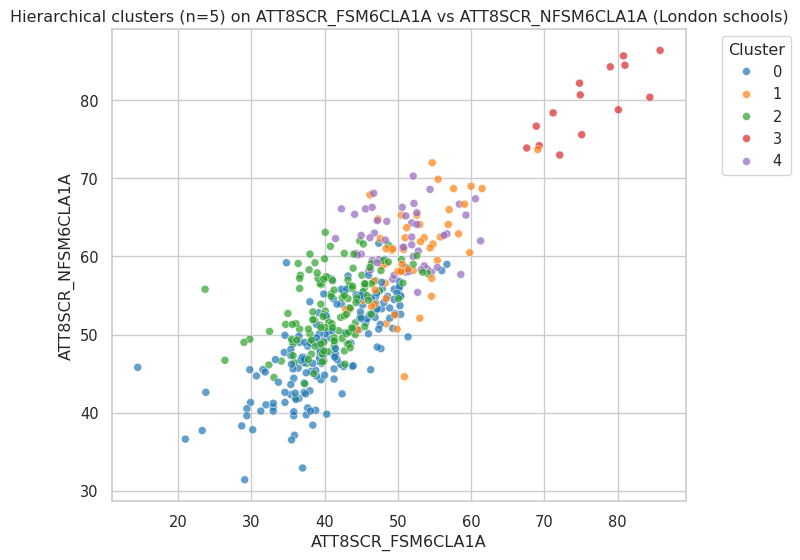

In [20]:
plt.figure()
sns.scatterplot(
    data=df_school_london,
    x=x_var, y=y_var,
    hue="cluster_hier",
    palette="tab10",
    alpha=0.7
)
plt.title(f"Hierarchical clusters (n={n_clusters_hier}) on {x_var} vs {y_var} (London schools)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

## Map London schools by cluster

Finally, we map the London schools in 2D space using their **easting**
and **northing** coordinates.

Each point represents a school, and the colour shows its cluster. This
is a simple scatter plot (not a full GIS map), but it still reveals
spatial patterns. We will map:

-   Once for **K-means** clusters.  
-   Once for **hierarchical** clusters.

### Map with K-means clusters

/tmp/ipykernel_34637/2539784033.py:29: DeprecationWarning:

The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.


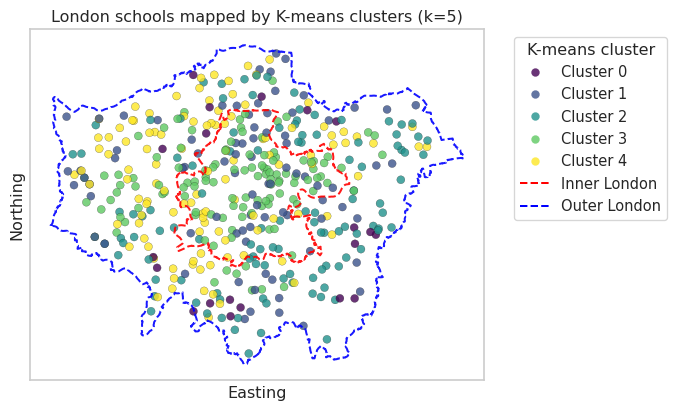

In [21]:
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

# --- read and prepare boundaries (do this once in the document) ---
url_geojson = "https://raw.githubusercontent.com/huanfachen/QM/refs/heads/main/sessions/L10_data/London_Boroughs.geojson"

gdf_boroughs = gpd.read_file(url_geojson)

gdf_boroughs["BOROUGH"] = gdf_boroughs["BOROUGH"].str.replace("&", "and")

# Reproject to British National Grid (EPSG:27700)
gdf_boroughs = gdf_boroughs.to_crs(epsg=27700)

# Merge with df_lad_county to get Inner / Outer London label
gdf_london = gdf_boroughs.merge(
    df_lad_county[["LAD24NM", "CTY24NM"]],
    left_on="BOROUGH",
    right_on="LAD24NM",
    how="inner"
)

# Dissolve into single polygons for Inner / Outer London
gdf_inner_outer = gdf_london.dissolve(by="CTY24NM")  # index: "Inner London", "Outer London"

# --- build a single 'outer London' boundary from ALL boroughs (Inner + Outer) ---
# union of all geometries gives whole London footprint
london_union = gdf_london.unary_union      # Polygon or MultiPolygon

# make GeoSeries so we can plot its boundary
gseries_london_union = gpd.GeoSeries([london_union], crs=gdf_london.crs)

plt.figure(figsize=(8, 8))

# --- scatter of schools, coloured by K-means cluster ---
scatter = plt.scatter(
    df_school_london["easting"],
    df_school_london["northing"],
    c=df_school_london["cluster_kmeans"],
    cmap="viridis",
    alpha=0.8,
    edgecolor="k",
    linewidth=0.2
)

ax = plt.gca()
ax.set_aspect("equal", "box")

# --- plot Inner London boundary (red, dashed) ---
inner_geom = gdf_inner_outer.loc["Inner London"].geometry
gpd.GeoSeries([inner_geom], crs=gdf_london.crs).boundary.plot(
    ax=ax,
    edgecolor="red",
    linewidth=1.5,
    linestyle="--",
    alpha=0.9
)

# --- plot Outer London *overall* boundary from all boroughs (blue, dashed) ---
gseries_london_union.boundary.plot(
    ax=ax,
    edgecolor="blue",
    linewidth=1.5,
    linestyle="--",
    alpha=0.9
)

plt.xlabel("Easting")
plt.ylabel("Northing")
plt.title(f"London schools mapped by K-means clusters (k={k_val})")

# --- legend for clusters ---
handles_clusters, _ = scatter.legend_elements(prop="colors", alpha=0.8)
labels_clusters = [f"Cluster {i}" for i in range(k_val)]

# --- legend for Inner / Outer London boundaries ---
inner_line = mlines.Line2D(
    [], [], color="red", linestyle="--", linewidth=1.5, label="Inner London"
)
outer_line = mlines.Line2D(
    [], [], color="blue", linestyle="--", linewidth=1.5, label="Outer London boundary"
)

# combine legends
handles_all = handles_clusters + [inner_line, outer_line]
labels_all = labels_clusters + ["Inner London", "Outer London"]

plt.legend(
    handles_all,
    labels_all,
    title="K-means cluster",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

plt.tight_layout()

# 1. Remove axis tick text (and ticks if you like)
ax.set_xticks([])
ax.set_yticks([])

plt.show()

### Map with hierarchical clusters

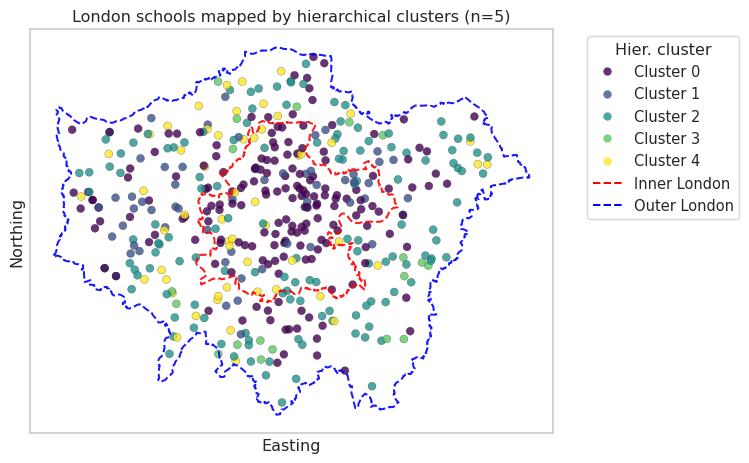

In [22]:
import matplotlib.lines as mlines

plt.figure(figsize=(8, 8))

# --- scatter of schools, coloured by hierarchical cluster ---
scatter_h = plt.scatter(
    df_school_london["easting"],
    df_school_london["northing"],
    c=df_school_london["cluster_hier"],
    cmap="viridis",
    alpha=0.8,
    edgecolor="k",
    linewidth=0.2
)

ax = plt.gca()
ax.set_aspect("equal", "box")

# --- plot Inner London boundary (red, dashed) ---
inner_geom = gdf_inner_outer.loc["Inner London"].geometry
gpd.GeoSeries([inner_geom], crs=gdf_london.crs).boundary.plot(
    ax=ax,
    edgecolor="red",
    linewidth=1.5,
    linestyle="--",
    alpha=0.9
)

# --- plot Outer London *overall* boundary from all boroughs (blue, dashed) ---
gseries_london_union.boundary.plot(
    ax=ax,
    edgecolor="blue",
    linewidth=1.5,
    linestyle="--",
    alpha=0.9
)

plt.xlabel("Easting")
plt.ylabel("Northing")
plt.title(f"London schools mapped by hierarchical clusters (n={n_clusters_hier})")

# --- legend for hierarchical clusters ---
handles_h, _ = scatter_h.legend_elements(prop="colors", alpha=0.8)
labels_h = [f"Cluster {i}" for i in range(n_clusters_hier)]

# --- legend entries for Inner / Outer London ---
inner_line = mlines.Line2D(
    [], [], color="red", linestyle="--", linewidth=1.5, label="Inner London"
)
outer_line = mlines.Line2D(
    [], [], color="blue", linestyle="--", linewidth=1.5, label="Outer London boundary"
)

# combine legends
handles_all = handles_clusters + [inner_line, outer_line]
labels_all = labels_clusters + ["Inner London", "Outer London"]

plt.legend(handles_all, labels_all,
           title="Hier. cluster",
           bbox_to_anchor=(1.05, 1), loc="upper left")

# 1. Remove axis tick text (and ticks if you like)
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

We’ve seen two maps of clusters of London schools, each with 5 clusters.
Please note that the cluster numbering (0-5) is nominal rather than
ordinal; it doesn’t indicate an order. In addition, we can’t compare
Cluster 0 from Kmeans with Cluster 0 from hierarchical clustering.

The Kmeans clustering map shows that most schools in Cluster 3 are in
Inner London, while most of the schools in Cluster 0 or 4 are outsider
Inner London.

In comparison, the hierarchical clustering map shows that Cluster 0 are
mostly in Inner London. For further analysis, we can link the clustering
with spatial or socio-economic variables to check why these clusters are
concentrated in space.

## You’re Done!

In this practical, we’ve used clustering analysis to inspect the
grouping of schools in London.

If you have time, you can now: - Try different variable subsets or add
in more variables on census and/or performance. - Add more
interpretation about what each cluster represents in educational terms.